# VAEについて調査&実装してみる

- 目的
    - VAEを生成モデルの代表的なものとみなして事後確率分布のモデル化が可能かを検証する
- 目標
    - 識別タスクをお題として、入力空間における分布$p(x|C_k)$をモデル化したのちにベイズの公式を用いて事後確率$p(C_k|x)$を実際に計算してみる
- 手段
    - mnist手書き数字にて、数字の0とそれ以外の2クラス識別タスクを学習。例えば6のように見える0は事後確率分布がばらつくかどうかを確かめてみる

## VAEによる確率分布$p(x|C_k)$のモデル化

VAEは生成モデルであるから$p(x|C_k)$をガウス分布として表現することができるはず。まずはこれを実装してみる。

適切に訓練できれば、数字をエンコーダに入力したときの出力がガウス分布に従っているはず。これを確かめてみよう。

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2023-11-05 02:24:12.809180: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-05 02:24:12.809439: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-05 02:24:12.810788: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-05 02:24:13.104549: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available:  1


2023-11-05 02:24:17.715294: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-05 02:24:17.821090: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-05 02:24:17.821129: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.utils import plot_model
import numpy as np
import matplotlib.pyplot as plt


In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [5]:
latent_dim = 2
batch_size = 128
epochs = 10

In [6]:
# エンコーダーの定義
inputs = Input(shape=(original_dim,), name='encoder_input')
x = Dense(512, activation='relu')(inputs)
x = Dense(256, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# 潜在変数のサンプリング関数の定義
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.keras.backend.random_normal(shape=(tf.keras.backend.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + tf.keras.backend.exp(z_log_var) * epsilon

# 潜在変数のサンプリング関数を使用して、潜在変数zを生成します。
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# デコーダーの定義
decoder_input = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(256, activation='relu')(decoder_input)
x = Dense(512, activation='relu')(x)
outputs = Dense(original_dim, activation='sigmoid')(x)

# エンコーダーとデコーダーを結合してVAEモデルを作成します。
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
decoder = Model(decoder_input, outputs, name='decoder')
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

2023-11-05 02:24:19.018322: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-05 02:24:19.018393: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-05 02:24:19.018416: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-05 02:24:19.437870: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-05 02:24:19.438003: I tensorflow/compile

In [7]:
reconstruction_loss = mse(inputs, outputs) * original_dim
kl_loss = 1 + z_log_var - tf.keras.backend.square(z_mean) - tf.keras.backend.exp(z_log_var)
kl_loss = tf.keras.backend.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = tf.keras.backend.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.fit(x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))

2023-11-05 02:24:20.784955: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.
2023-11-05 02:24:20.944511: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


Epoch 1/10


2023-11-05 02:24:23.868033: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f31191fdab0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-05 02:24:23.868090: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2060 SUPER, Compute Capability 7.5
2023-11-05 02:24:23.897839: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-05 02:24:23.979509: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2023-11-05 02:24:24.160562: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


469/469 [==============================] - 10s 13ms/step - loss: 47.2778 - val_loss: 40.7330
Epoch 2/10
469/469 [==============================] - 6s 13ms/step - loss: 39.3100 - val_loss: 38.1646
Epoch 3/10
469/469 [==============================] - 6s 13ms/step - loss: 37.2658 - val_loss: 36.5425
Epoch 4/10
469/469 [==============================] - 6s 12ms/step - loss: 36.0959 - val_loss: 35.6156
Epoch 5/10
469/469 [==============================] - 6s 12ms/step - loss: 35.3335 - val_loss: 35.1558
Epoch 6/10
469/469 [==============================] - 6s 12ms/step - loss: 34.8004 - val_loss: 34.5757
Epoch 7/10
469/469 [==============================] - 6s 12ms/step - loss: 34.4105 - val_loss: 34.3924
Epoch 8/10
469/469 [==============================] - 6s 13ms/step - loss: 34.0962 - val_loss: 34.0622
Epoch 9/10
469/469 [==============================] - 6s 12ms/step - loss: 33.7742 - val_loss: 33.5876
Epoch 10/10
469/469 [==============================] - 6s 12ms/step - loss: 33.4862

## 潜在空間の適当な値を画像化してみる
ここまででVAEの学習はできているはず。試しに適当な潜在空間の値$z$を指定して画像化してみる。

1/1 [==============================] - 0s 20ms/step


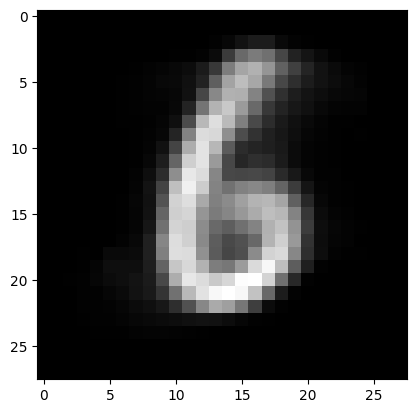

In [17]:
# 数字の潜在表現を生成します。
# ここの値を色々変えると生成される数字も変化する
# おかしな値を入れると画像も破綻する
latent_representation = np.array([[0.2,0.5]])

# デコーダーを使用して、数字6の画像を生成します。
generated_image = decoder.predict(latent_representation)

# 生成された画像を表示します。
plt.imshow(generated_image.reshape(28,28), cmap="gray")
plt.show()

In [18]:
x = np.arange(-1, 1.1, 0.5)
y = np.arange(-1, 1.1, 0.5)

xx, yy = np.meshgrid(x, y)
data = np.array([xx.ravel(), yy.ravel()]).T

In [19]:
list_generated_image = []
for i in data:
    # print(i.reshape(1,2).shape)
    list_generated_image.append(decoder.predict(i.reshape(1,2)))

1/1 [==============================] - 0s 17ms/step


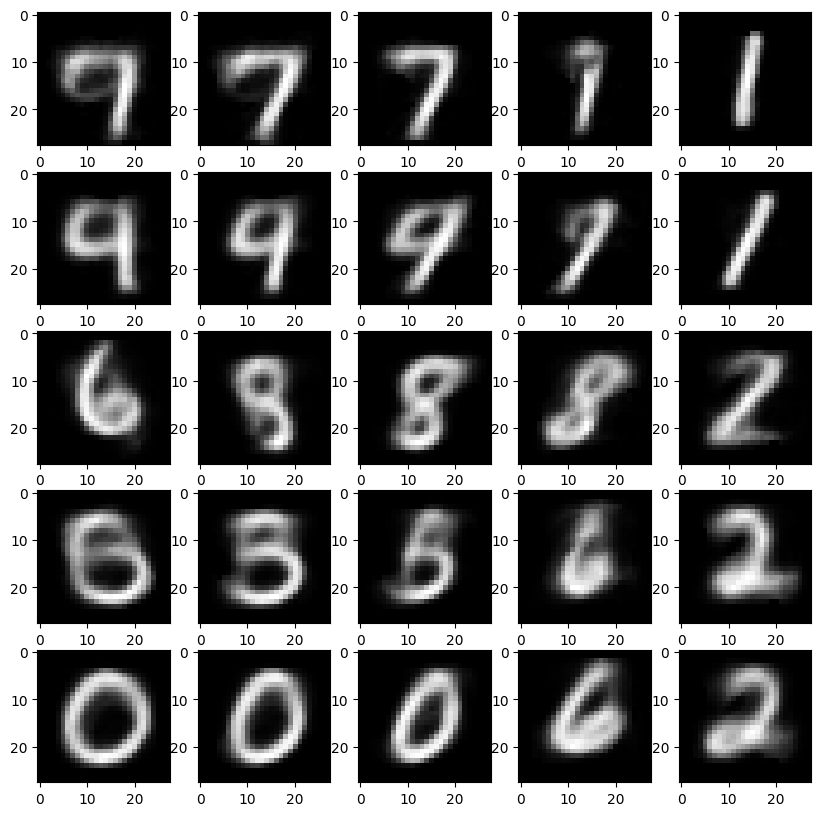

In [12]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(5, 5, figsize=(10, 10))
cnt=0
for i in range(5):
    for j in range(5):
        axs[i, j].imshow(list_generated_image[cnt].reshape(28,28), cmap="gray")
        cnt+=1
plt.show()

グリッド上に潜在空間をの値を画像化してみるとだんだんと数字が変化しているように見える。なかなか面白い。

## 潜在空間の分布を可視化してみる
さて、このモデルが潜在空間を正規分布として表現できているのかを可視化してみる。

と思ったのだがここで重大なことに気が付いた。VAEは潜在空間の分布$p(z)$を正規分布にしてくれはするものの、サンプル$x$を潜在変数$z$に変換できない。VAEのエンコーダは$p(z)$の平均と共分散行列を出力してくれるだけなので。

まあそれは仕方ないとして。ちょっと気になったので、エンコーダに画像を入力したら実際何が出てくるのか見てみる。

ん－、エンコーダの出力（平均と分散）ガウス分布からのサンプリングを潜在変数への変換とみなす向きもあるっぽいな。サンプル$x$をエンコードすると潜在空間でガウス分布になると解釈していいのかな？